## 代码测试 notebook

构建测试环境，使能够索引模块路径

In [1]:
%cd /home/brhu/WorkStation/Programming/Python/detr-s
import os
import sys
 
cur_dir = os.getcwd()
pkg_rootdir = cur_dir
# pkg_rootdir = os.path.dirname(cur_dir)
# pkg_rootdir = os.path.dirname(os.path.dirname(cur_dir))
print(pkg_rootdir)
if pkg_rootdir not in sys.path:
    sys.path.append(pkg_rootdir)

/home/brhu/WorkStation/Programming/Python/detr-s
/home/brhu/WorkStation/Programming/Python/detr-s


### 测试 backbone类

In [2]:
# test code for models.backbone
import torch
from models.backbone import Backbone

name = 'resnet18'  # Example backbone name
train_backbone = True  # Example train_backbone value
return_interm_layers = True  # Example return_interm_layers value
dilation = False  # Example dilation value

backbone_instance = Backbone(name, train_backbone, return_interm_layers, dilation)
# 打印模型结构信息
print(backbone_instance)

# torch.save(backbone_instance.state_dict(), 'backbone.pth')

Backbone(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d()
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d()
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d()
      )
    )
    (layer2): Sequential(
   

### 测试位置编码类

/home/brhu/WorkStation/Programming/Python/detr-s/models/position_encoding.py:35: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


torch.Size([2, 256, 25, 25])


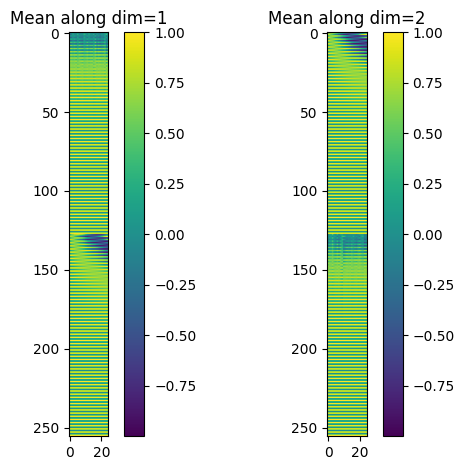

In [3]:
from models.position_encoding import PositionEmbeddingSine
import matplotlib.pyplot as plt
from util.misc import NestedTensor

# 创建一个示例输入
batch_size = 2
tensor = torch.randn(batch_size, 25, 25)
# 创建掩码
mask_shape = (batch_size, 25, 25)
mask = torch.rand(mask_shape) > 0.5
# mask = torch.rand(3, 25, 25, dtype=torch.bool)
tensor_list = NestedTensor(tensor, mask)

# 实例化类
pos_embedding = PositionEmbeddingSine(num_pos_feats=128, normalize=True, scale=None)

# 调用 forward 方法计算位置编码
pos_embed = pos_embedding(tensor_list)

print(pos_embed.shape)

# 可视化位置编码结果
# plt.imshow(output[0].mean(dim=0).detach().numpy(), cmap='hot')
# plt.colorbar()
# plt.show()

fig, axs = plt.subplots(1, 2)

# 在第一个子图中绘制图像1
im1 = axs[0].imshow(pos_embed[0].mean(dim=1).detach().numpy(), cmap='viridis')
axs[0].set_title('Mean along dim=1')
fig.colorbar(im1, ax=axs[0])

# 在第二个子图中绘制图像2
im2 = axs[1].imshow(pos_embed[0].mean(dim=2).detach().numpy(), cmap='viridis')
axs[1].set_title('Mean along dim=2')
fig.colorbar(im2, ax=axs[1])

# 调整子图之间的距离
fig.tight_layout()

# 显示图形
plt.show()

### 测试 Transformer类

In [4]:
from models.transformer import Transformer
import torch.nn as nn

# 创建示例输入
src = torch.rand(batch_size, 256, 25, 25)  # 输入序列
# # 创建掩码
# mask_shape = (2, 25, 25)
# mask = torch.rand(mask_shape) > 0.5
tensor = NestedTensor(src, mask)

d_model = src.shape[1]
transformer_instance = Transformer(d_model=d_model, nhead=8, num_encoder_layers=6,
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False,
                 return_intermediate_dec=False)
num_queries = 100
hidden_dim = d_model
query_embed = nn.Embedding(num_queries, hidden_dim)
print(query_embed)

hs, memory = transformer_instance(tensor.tensors, tensor.mask, query_embed.weight, pos_embed=pos_embed)

print(hs.shape)
print(memory.shape)

Embedding(100, 256)
torch.Size([1, 2, 100, 256])
torch.Size([2, 256, 25, 25])


### 测试 DETR 模型

In [5]:
from models.detr import DETR, PostProcess
from models.backbone import Joiner

backbone = Joiner(backbone_instance, pos_embedding)
backbone.num_channels = backbone_instance.num_channels
transformer = transformer_instance  # 定义您的transformer模型
num_classes = 91  # 定义目标类别数量
num_queries = 100  # 定义查询数量
detr_model = DETR(backbone, transformer, num_classes, num_queries)

# 创建一个示例输入
image = torch.randn(batch_size, 3, 640, 640)  # 输入图像，假设为224x224大小的RGB图像
# samples = [{'tensor': image, 'mask': None}]  # 构建NestedTensor示例
samples = image

output = detr_model(samples)

pred_logits = output['pred_logits']
pred_boxes = output['pred_boxes']

print(pred_logits.shape)
print(pred_boxes.shape)

# 网络结果后处理
postprocess = PostProcess()
detections = postprocess(output, torch.ones(batch_size, 2)*640)

print(detections[0].keys())
# print(detections)

torch.Size([2, 100, 92])
torch.Size([2, 100, 4])
dict_keys(['scores', 'labels', 'boxes'])


### 测试匈牙利算法

In [6]:
test_tensor = torch.randn(2, 100, 92)
test_tensor = test_tensor.flatten(0, 1)
print(test_tensor.shape)

test_tensor = test_tensor.softmax(-1)
print(test_tensor.shape)

x1 = torch.tensor([[1, 1, 1, 1], [3, 3, 1, 1], [2, 2, 1, 1]], dtype=float)  # 第一组点的坐标
x2 = torch.tensor([[1.5, 1, 1, 1], [1, 1.5, 1, 1]], dtype=float)  # 第二组点的坐标

distances = torch.cdist(x1, x2, p=2)  # 计算欧氏距离
print(distances)

torch.Size([200, 92])
torch.Size([200, 92])
tensor([[0.5000, 0.5000],
        [2.5000, 2.5000],
        [1.1180, 1.1180]], dtype=torch.float64)


In [7]:
from engine.matcher import HungarianMatcher

matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)

# 创建真实标签
gt_target = detections

i, j = matcher(output, gt_target)

print(i)
print(j)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), tensor([ 0,  8, 25, 23,  7, 71,  6, 11,  5, 49, 24, 32, 38, 89, 93, 66, 39, 72,
        69, 34, 21,  9, 14, 92, 64, 27,  1, 33, 83, 40, 74, 82, 90, 98, 45, 35,
        30, 68, 19, 65, 96, 75, 87, 16, 41, 18, 51, 55, 28, 94, 76, 80, 48, 44,
        57, 20, 50, 37, 58, 62, 54, 12, 59, 29, 22, 78, 43, 86, 56, 85, 73, 17,
        95, 52, 46, 42, 31,  4, 61, 60, 77, 26, 70, 67,  2,  3, 15, 63, 99, 13,
        10, 91, 97, 84, 47, 81, 53, 36, 88, 79]))
(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20

### 测试模型训练

In [8]:
# %run train.py --coco_path /data/COCO2017/images/  \
#     --output_dir run/box_model \
#     --epochs 3 --device cuda --num_workers 8 --batch_size 2

### 测试模型推理

In [9]:
model_path = 'run/box_model/detr-r50-e632da11.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_dict = torch.load(model_path, map_location=device)

print(model_dict['model'].keys())

odict_keys(['transformer.encoder.layers.0.self_attn.in_proj_weight', 'transformer.encoder.layers.0.self_attn.in_proj_bias', 'transformer.encoder.layers.0.self_attn.out_proj.weight', 'transformer.encoder.layers.0.self_attn.out_proj.bias', 'transformer.encoder.layers.0.linear1.weight', 'transformer.encoder.layers.0.linear1.bias', 'transformer.encoder.layers.0.linear2.weight', 'transformer.encoder.layers.0.linear2.bias', 'transformer.encoder.layers.0.norm1.weight', 'transformer.encoder.layers.0.norm1.bias', 'transformer.encoder.layers.0.norm2.weight', 'transformer.encoder.layers.0.norm2.bias', 'transformer.encoder.layers.1.self_attn.in_proj_weight', 'transformer.encoder.layers.1.self_attn.in_proj_bias', 'transformer.encoder.layers.1.self_attn.out_proj.weight', 'transformer.encoder.layers.1.self_attn.out_proj.bias', 'transformer.encoder.layers.1.linear1.weight', 'transformer.encoder.layers.1.linear1.bias', 'transformer.encoder.layers.1.linear2.weight', 'transformer.encoder.layers.1.linear2

In [10]:
tensor1 = torch.ones([1, 100, 92])
print(len(tensor1))
tensor2 = torch.randn([1, 3, 720, 1280])
tensor3 = torch.tensor(tensor2.shape[-2:]).unsqueeze(0)
print(tensor3.shape)

1
torch.Size([1, 2])


In [11]:
import yaml

# 读取 YAML 文件
with open('datasets/coco.yaml', 'r') as file:
    data = yaml.safe_load(file)

print(data)
# 将读取的数据转换为字典
parameters = dict(data)
# 打印参数字典
print(parameters)

{'train': '/data/COCO2017/images/train2017', 'val': '/data/COCO2017/images/val2017', 'test': '/data/COCO2017/images/test2017', 'anno_path': '/data/COCO2017/annotations/instances_val2017.json', 'nc': 80, 'is_coco': True, 'names': ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'ref

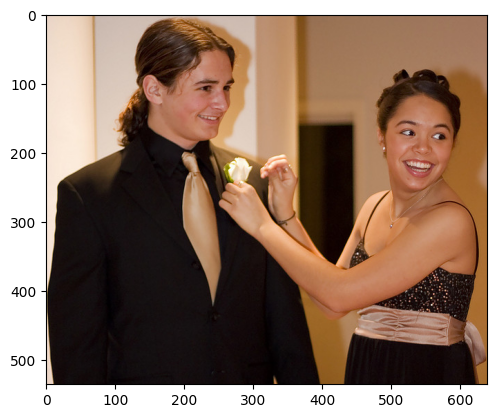

/home/brhu/WorkStation/Programming/Python/detr-s/models/position_encoding.py:35: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


class predict size:  torch.Size([1, 100, 92])
boxes predict size:  torch.Size([1, 100, 4])
image size:  torch.Size([1, 3, 536, 640])
target size:  torch.Size([1, 2])
outputs size:  torch.Size([100, 6])
b'snowboard 0.99' 198 193 414 252
b'person 0.99' 4 0 531 398
b'person 1.00' 81 241 533 637


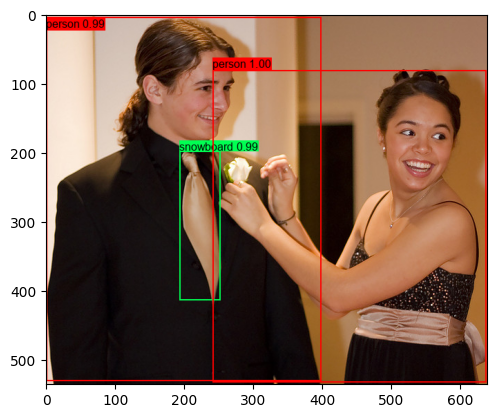

results size:  1
[tensor([[1.9850e+02, 1.9347e+02, 4.1495e+02, 2.5230e+02, 9.9448e-01, 3.2000e+01],
        [4.4055e+00, 5.9513e-01, 5.3143e+02, 3.9896e+02, 9.9235e-01, 1.0000e+00],
        [8.1395e+01, 2.4104e+02, 5.3354e+02, 6.3712e+02, 9.9876e-01, 1.0000e+00]],
       device='cuda:0')]


In [12]:
%run predict.py